In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
# LOAD PREPROCESSED DATA

train = pd.read_csv("data_train.csv", parse_dates=['date_time'], index_col='date_time')
test = pd.read_csv("data_test.csv", parse_dates=['date_time'], index_col='date_time')

print(f"\nTrain: {train.index.min()} to {train.index.max()} ({len(train)} hours)")
print(f"Test:  {test.index.min()} to {test.index.max()} ({len(test)} hours)")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")


Train: 2012-03-12 14:00:00 to 2018-09-06 21:00:00 (15248 hours)
Test:  2018-09-06 22:00:00 to 2018-12-09 23:00:00 (720 hours)
Train shape: (15248, 70)
Test shape: (720, 70)


In [6]:
# 2. FEATURE SELECTION

feature_cols = [
    # Time features
    'hour', 'dayofweek', 'month',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    
    # Weather features
    'temp_c', 'rain_1h', 'snow_1h', 'clouds_all',
    
    # Lag features
    'traffic_lag_1', 'traffic_lag_24', 'traffic_lag_168',
    
    # Rolling statistics
    'traffic_rolling_mean_24', 'traffic_rolling_std_24',
    
    # Holiday indicator
    'is_holiday'
]

# Add weather category dummies if they exist
weather_main_cols = [c for c in train.columns if c.startswith('weather_main_')]
weather_desc_cols = [c for c in train.columns if c.startswith('weather_description_')]
holiday_cols = [c for c in train.columns if c.startswith('holiday_') and c != 'is_holiday']

feature_cols += weather_main_cols + weather_desc_cols + holiday_cols

# Filter to only existing columns
feature_cols = [c for c in feature_cols if c in train.columns]


In [7]:
# 3. PREPARE TRAIN/TEST SETS

# Separate features and target
X_train = train[feature_cols].copy()
y_train = train['traffic_volume'].copy()
X_test = test[feature_cols].copy()
y_test = test['traffic_volume'].copy()

# Check for any remaining NaNs
print(f"\nNaNs in X_train: {X_train.isna().sum().sum()}")
print(f"NaNs in X_test: {X_test.isna().sum().sum()}")
print(f"NaNs in y_train: {y_train.isna().sum()}")
print(f"NaNs in y_test: {y_test.isna().sum()}")

# CRITICAL: Scale features AFTER split (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nX_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")



NaNs in X_train: 0
NaNs in X_test: 0
NaNs in y_train: 0
NaNs in y_test: 0

X_train_scaled shape: (15248, 66)
X_test_scaled shape: (720, 66)


In [8]:
# 4. BASELINE MODELS

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, 
                                                   random_state=42, max_depth=5)
}

# Train and evaluate
baseline_results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    baseline_results[name] = {
        "Train RMSE": train_rmse,
        "Test RMSE": test_rmse,
        "Train MAE": train_mae,
        "Test MAE": test_mae,
        "Train R²": train_r2,
        "Test R²": test_r2
    }
    
    print(f"Train → RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
    print(f"Test  → RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

# Display results
baseline_df = pd.DataFrame(baseline_results).T

print(baseline_df.to_string())




--- Training Linear Regression ---
Train → RMSE: 739.31, MAE: 514.94, R²: 0.8603
Test  → RMSE: 679.03, MAE: 492.93, R²: 0.8833

--- Training Random Forest ---
Train → RMSE: 131.92, MAE: 77.66, R²: 0.9956
Test  → RMSE: 263.76, MAE: 181.93, R²: 0.9824

--- Training Gradient Boosting ---
Train → RMSE: 270.59, MAE: 183.18, R²: 0.9813
Test  → RMSE: 271.73, MAE: 193.31, R²: 0.9813
                   Train RMSE   Test RMSE   Train MAE    Test MAE  Train R²  Test R²
Linear Regression  739.309943  679.031235  514.938121  492.931370  0.860312  0.88329
Random Forest      131.923181  263.760635   77.662604  181.933333  0.995552  0.98239
Gradient Boosting  270.586883  271.729903  183.181946  193.309459  0.981288  0.98131


In [9]:
# 5. HYPERPARAMETER TUNING (Random Forest)

# Define parameter distribution
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.5]
}

# Use TimeSeriesSplit for cross-validation (respects temporal order)
tscv = TimeSeriesSplit(n_splits=3)

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print("\nRunning RandomizedSearchCV with TimeSeriesSplit...")
random_search.fit(X_train_scaled, y_train)

print("\nBest Parameters:", random_search.best_params_)
print(f"Best CV Score (neg MSE): {random_search.best_score_:.2f}")



Running RandomizedSearchCV with TimeSeriesSplit...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 478}
Best CV Score (neg MSE): -128208.40


In [10]:
#6. EVALUATE TUNED MODEL

best_rf = random_search.best_estimator_

# Predictions
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nTuned Random Forest:")
print(f"Train → RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, R²: {train_r2:.4f}")
print(f"Test  → RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, R²: {test_r2:.4f}")

# Check for overfitting
overfitting_gap = train_r2 - test_r2
print(f"\nOverfitting check: Train R² - Test R² = {overfitting_gap:.4f}")
if overfitting_gap > 0.05:
    print("Warning: Possible overfitting detected")
else:
    print("Model generalizes well")



Tuned Random Forest:
Train → RMSE: 203.91, MAE: 115.42, R²: 0.9894
Test  → RMSE: 259.61, MAE: 179.43, R²: 0.9829

Overfitting check: Train R² - Test R² = 0.0064
Model generalizes well



Top 15 Most Important Features:
                Feature  Importance
          traffic_lag_1    0.497775
               hour_cos    0.256057
                   hour    0.159638
               hour_sin    0.033442
         traffic_lag_24    0.021284
traffic_rolling_mean_24    0.012559
 traffic_rolling_std_24    0.006255
                 temp_c    0.004057
        traffic_lag_168    0.003352
                  month    0.001245
             clouds_all    0.000871
                dow_sin    0.000732
              dayofweek    0.000679
                dow_cos    0.000430
    weather_main_Clouds    0.000218


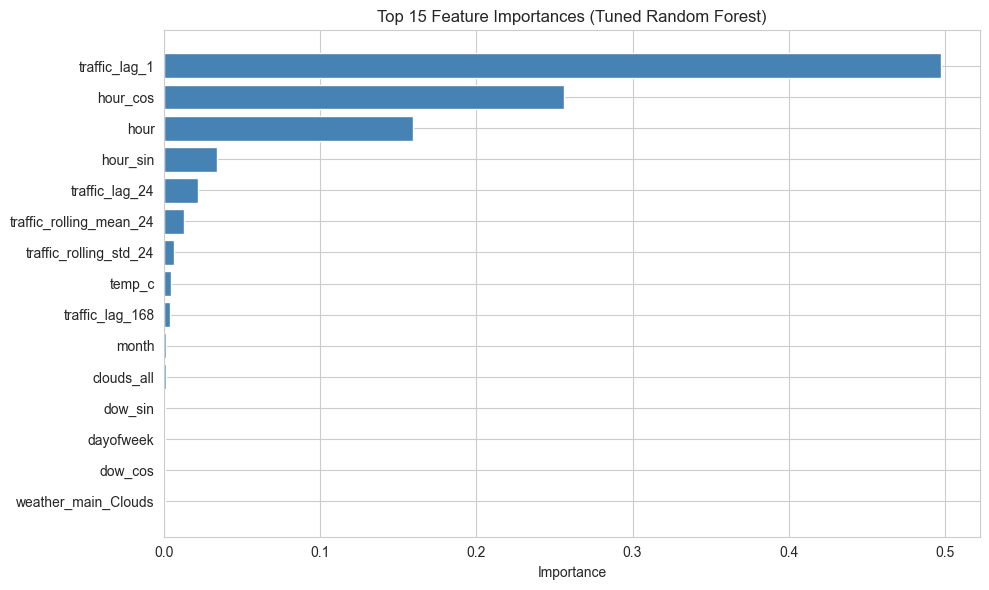

In [11]:
# 7. FEATURE IMPORTANCE ANALYSIS

# Get feature importances
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Plot top 15
top_n = 15
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), top_features['Importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['Feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (Tuned Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

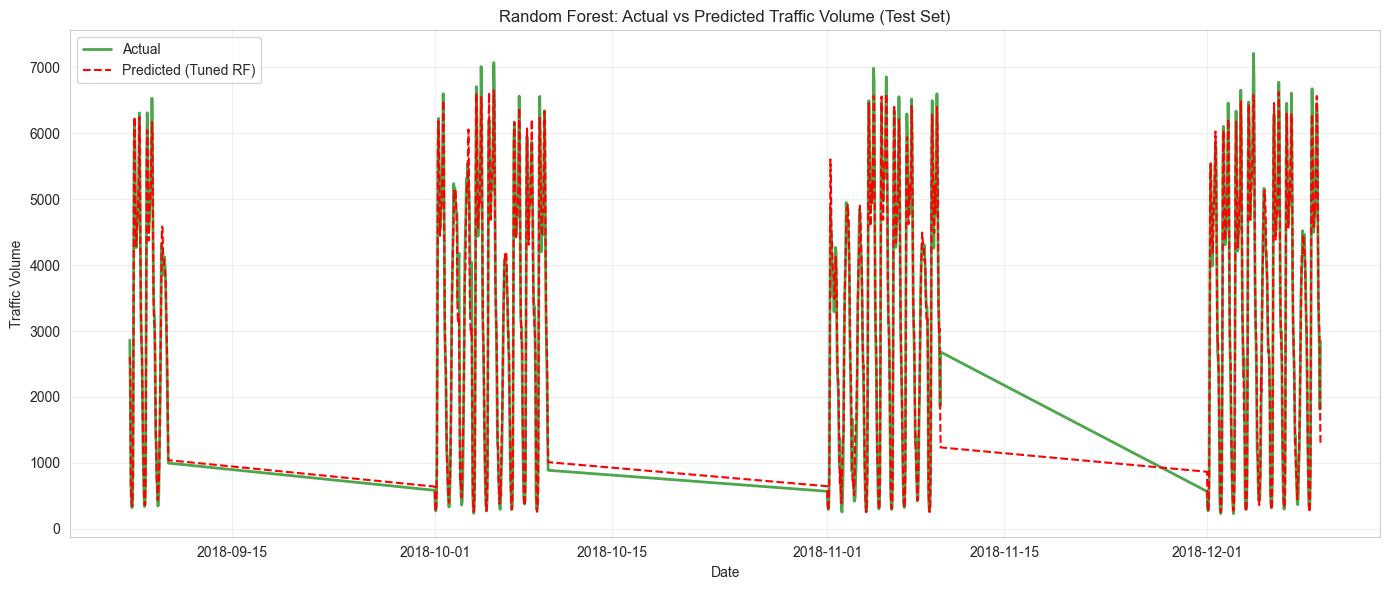

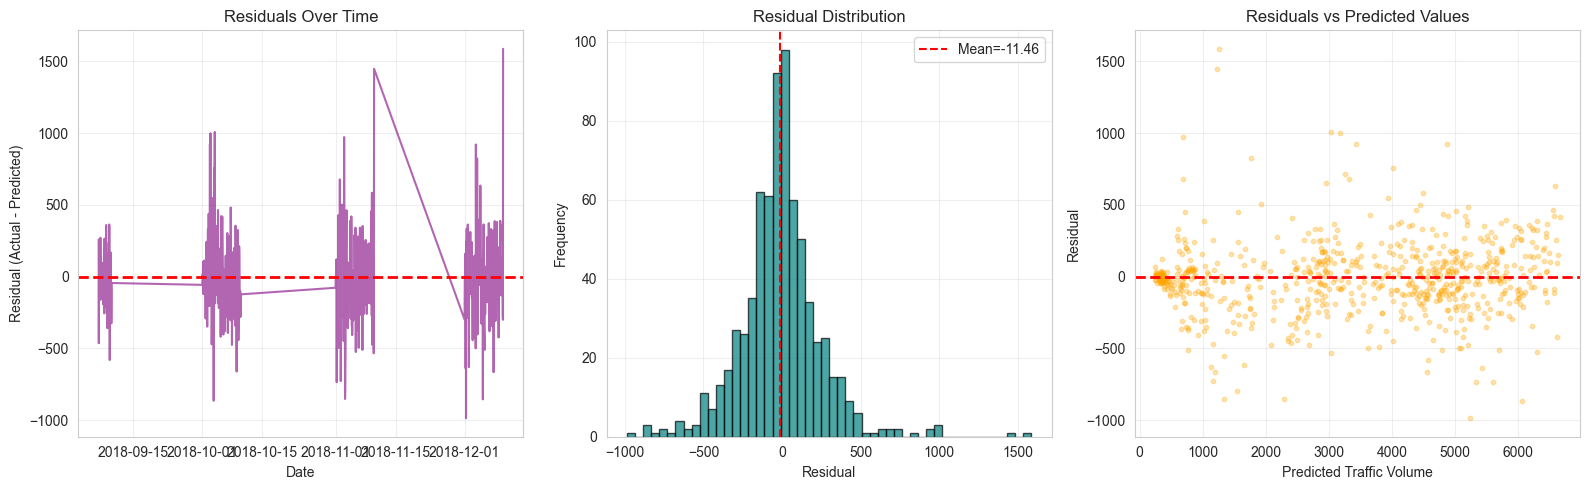


Residual Statistics:
count     720.000000
mean      -11.455257
std       259.534926
min      -986.094559
25%      -130.832256
50%       -12.086995
75%       104.669461
max      1586.791140
dtype: float64


In [12]:
# 8. VISUALIZATIONS

#Actual vs Predicted (Test Set)
plt.figure(figsize=(14, 6))
plt.plot(test.index, y_test.values, label='Actual', color='green', linewidth=2, alpha=0.7)
plt.plot(test.index, y_test_pred, label='Predicted (Tuned RF)', color='red', 
         linestyle='--', linewidth=1.5)
plt.title('Random Forest: Actual vs Predicted Traffic Volume (Test Set)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residual Analysis
residuals = y_test.values - y_test_pred

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Residuals over time
axes[0].plot(test.index, residuals, color='purple', alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Residuals Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual (Actual - Predicted)')
axes[0].grid(alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=50, color='teal', alpha=0.7, edgecolor='black')
axes[1].axvline(residuals.mean(), color='red', linestyle='--', 
                label=f'Mean={residuals.mean():.2f}')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Residuals vs Predicted
axes[2].scatter(y_test_pred, residuals, alpha=0.3, color='orange', s=10)
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Residuals vs Predicted Values')
axes[2].set_xlabel('Predicted Traffic Volume')
axes[2].set_ylabel('Residual')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("\nResidual Statistics:")
print(pd.Series(residuals).describe())

In [13]:
# 9. COMPARISON WITH NAIVE BASELINE

if 'traffic_lag_168' in test.columns:
    naive_pred = test['traffic_lag_168'].values
    
    # Remove NaNs if any
    valid_idx = ~np.isnan(naive_pred)
    naive_pred_clean = naive_pred[valid_idx]
    y_test_clean = y_test.values[valid_idx]
    
    naive_rmse = np.sqrt(mean_squared_error(y_test_clean, naive_pred_clean))
    naive_mae = mean_absolute_error(y_test_clean, naive_pred_clean)
    naive_r2 = r2_score(y_test_clean, naive_pred_clean)
    
    print(f"\nNaive Seasonal Baseline (lag 168h):")
    print(f"RMSE: {naive_rmse:.2f}, MAE: {naive_mae:.2f}, R²: {naive_r2:.4f}")
    
    print(f"\nRandom Forest Improvement over Naive:")
    print(f"RMSE reduction: {((naive_rmse - test_rmse) / naive_rmse * 100):.1f}%")
    print(f"MAE reduction: {((naive_mae - test_mae) / naive_mae * 100):.1f}%")
else:
    print("\nWarning: traffic_lag_168 not available for naive baseline")



Naive Seasonal Baseline (lag 168h):
RMSE: 1493.89, MAE: 979.73, R²: 0.4351

Random Forest Improvement over Naive:
RMSE reduction: 82.6%
MAE reduction: 81.7%


In [14]:
#  10. SUMMARY

final_results = {
    "Model": "Tuned Random Forest",
    "Train RMSE": train_rmse,
    "Test RMSE": test_rmse,
    "Train MAE": train_mae,
    "Test MAE": test_mae,
    "Train R²": train_r2,
    "Test R²": test_r2,
    "Parameters": str(random_search.best_params_)
}

for key, value in final_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

Model: Tuned Random Forest
Train RMSE: 203.9092
Test RMSE: 259.6075
Train MAE: 115.4150
Test MAE: 179.4267
Train R²: 0.9894
Test R²: 0.9829
Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 478}


In [15]:
#SAVE RANDOM FOREST RESULTS TO CSV

# Create results DataFrame
rf_results = pd.DataFrame([{
    'Model': 'Random_Forest_Tuned',
    'N_Features': len(feature_cols),
    'Best_Params': str(random_search.best_params_),
    'Train_RMSE': train_rmse,
    'Test_RMSE': test_rmse,
    'Train_MAE': train_mae,
    'Test_MAE': test_mae,
    'Train_R2': train_r2,
    'Test_R2': test_r2,
    'Overfitting_Gap': overfitting_gap
}])

rf_results.to_csv('rf_results.csv', index=False)
print("\nRandom Forest results saved to 'rf_results.csv'")
print(rf_results.to_string(index=False))

# # Save feature importances to separate CSV
# feature_importance_df.to_csv('rf_feature_importances.csv', index=False)
# print("\nFeature importances saved to 'rf_feature_importances.csv'")


Random Forest results saved to 'rf_results.csv'
              Model  N_Features                                                                                                  Best_Params  Train_RMSE  Test_RMSE  Train_MAE   Test_MAE  Train_R2  Test_R2  Overfitting_Gap
Random_Forest_Tuned          66 {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 478}  203.909187 259.607488 115.415002 179.426657  0.989374 0.982941         0.006433


In [16]:
import joblib, os

# Save the tuned model for deployment
os.makedirs('models', exist_ok=True)
joblib.dump(best_rf, 'models/random_forest.pkl')
print("\n Tuned Random Forest model saved successfully at 'models/random_forest.pkl'")


 Tuned Random Forest model saved successfully at 'models/random_forest.pkl'


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Example combined pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_rf)
])

# Fit on training data
pipeline.fit(X_train, y_train)

# Save the whole pipeline instead of just model
import joblib, os
os.makedirs('models', exist_ok=True)
joblib.dump(pipeline, 'models/traffic_pipeline.pkl')


['models/traffic_pipeline.pkl']